# DEEP LEARNING MODEL

### Import Libraries

In [34]:
import pandas as pd
import nltk
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
import joblib

In [35]:
# Download NLTK Data
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Loading the dataset

In [36]:
df = pd.read_csv('C:\\group-1-main\\Data-Preprocessing\\labeled_data.csv')
df.shape

(24783, 7)

### Remove Usernames

In [37]:
def remove_usernames(tweet):
    return re.sub(r'@\w+', '', tweet)
df['tweet'] = df['tweet'].apply(remove_usernames)
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitc...
3,3,3,0,2,1,1,!!!!!!!!! RT : she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


### Remove Sequence

In [38]:
def remove_sequence(tweet):
    return re.sub(r'\b\d+\b', '', tweet)

df['tweet'] = df['tweet'].apply(remove_sequence)
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitc...
3,3,3,0,2,1,1,!!!!!!!!! RT : she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


### Remove URLS

In [39]:
def remove_urls(tweet):
    return re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+', '', tweet, flags=re.MULTILINE)

df['tweet'] = df['tweet'].apply(remove_urls)
df['tweet'] = df['tweet'].str.lower()

### Remove Punctuations

In [40]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet'] = df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt as a woman you shouldnt complain about cl...
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat ...
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she st...
3,3,3,0,2,1,1,rt she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true ...


### Managing Abbrevations

In [41]:

def replace_words(tweet, abbreviations_dict):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in abbreviations_dict.keys()) + r')\b')
    return pattern.sub(lambda x: abbreviations_dict[x.group()], tweet)

In [42]:
abbreviations_dict = {
    "dr": "doctor",
    "mr": "mister",
    "mrs": "mistress",
    "ms": "miss",
    "prof": "professor",
    "st": "saint",
    "sr": "senior",
    "jr": "junior",
    "lt": "lieutenant",
    "col": "colonel",
    "gen": "general",
    "rev": "reverend",
    "hon": "honorable",
    "lol": "laughing out loud",
    "idk": "i do not know",
    "tbh": "to be honest",
    "imo": "in my opinion",
    "btw": "by the way",
    "omg": "oh my god",
    "brb": "be right back",
    "ttyl": "talk to you later",
    "fr": "for real",
    "u": "you",
    "dat": "that",
    "smh": "shake my head",
    "txt": "text",
    "ima": "i am going to",
    "youll": "you all",
    "lmfao": "laugh my fucking ass off",
    "amp": "and",
    "def": "definitely",
    "lmao": "laugh my ass off",
    "ig": "instagram",
    "im": "i am",
    "id": "identification",
    "ur": "your",
    "ppl": "people",
    "jus": "just",
    "dwn": "down",
    "idc": "i do not care",
    "wcw": "woman crush wednesday",
    "smfh": "shaking my fucking head",
    "tf": "the fuck",
    "foh": "fuck outta here",
    "iguess": "i guess",
    "gtfo": "get the fuck out",
    "omfg": "oh my fucking god",
    "ucf": "university of central florida",
    "rft": "roll field trash",
    "lmfaoooo": "laughing my fucking ass off",
    "af": "as fuck",
    "fohead": "forehead",
    "gtgtgt": "got to go to get",
    "scally": "british slang for a young working-class person",
    "mtvhottest": "mtvs hottest",
    "lmaoo": "laughing my ass off",
    "bc": "because",
    "dm": "direct message",
    "dmv": "department of motor vehicles",
    "fb": "facebook",
    "gf": "girlfriend",
    "gt": "got",
    "lmmfao": "laughing my motherfucking ass off",
    "plz": "please",
    "tho": "though",
    "wtf": "what the fuck",
    "ya": "you",
    "mr": "mister",
    "frfr": "for real for real",
    "rn": "right now",
    "asap": "as soon as possible",
    "finna": "fixing to (going to)",
    "yall": "you all",
    "stfu": "shut the fuck up",
    "kikis": "a fun gathering",
    "ummmmm": "an exclamation (informal)",
    "ymxb": "a mathematical equation format",
    "kno": "know",
    "bby": "baby",
    "cc": "community college or carbon copy",
    "woof woof": "a playful expression, mimicking a dog s bark",
    "bae": "before anyone else",
    "oomf": "one of my followers (on social media)",
    "wop": "a racial slur or a dance move",
    "yo": "your",
    "atm": "at the moment",
    "nfl": "national football league",
    "4ao": "for adults only",
    "am": "before midday",
    "a3": "anytime anywhere anyplace",
    "aamof": "as a matter of fact",
    "acct": "account",
    "adih": "another day in hell",
    "afaic": "as far as i am concerned",
    "afaict": "as far as i can tell",
    "afaik": "as far as i know",
    "afair": "as far as i remember",
    "afk": "away from keyboard",
    "app": "application",
    "approx": "approximately",
    "apps": "applications",
    "asl": "age, sex, location",
    "atk": "at the keyboard",
    "ny" :"not yet",
    "lmaooooooooooo": "lauhing my ass out",
    "ave": "avenue",
    "aymm": "are you my mother",
    "ayor": "at your own risk",
    "b&b": "bed and breakfast",
    "b+b": "bed and breakfast",
    "bc": "before christ",
    "b2b": "business to business",
    "b2c": "business to customer",
    "b4": "before",
    "b4n": "bye for now",
    "b@u": "back at you",
    "bak": "back at keyboard",
    "bbbg": "bye bye be good",
    "bbc": "british broadcasting corporation",
    "bbias": "be back in a second",
    "bbl": "be back later",
    "bbs": "be back soon",
    "be4": "before",
    "bfn": "bye for now",
    "blvd": "boulevard",
    "bout": "about",
    "bros": "brothers",
    "brt": "be right there",
    "bsaaw": "big smile and a wink",
    "bwl": "bursting with laughter",
    "c/o": "care of",
    "cet": "central european time",
    "cf": "compare",
    "cia": "central intelligence agency",
    "csl": "can not stop laughing",
    "cu": "see you",
    "cul8r": "see you later",
    "cv": "curriculum vitae",
    "cwot": "complete waste of time",
    "cya": "see you",
    "cyt": "see you tomorrow",
    "dae": "does anyone else",
    "dbmib": "do not bother me i am busy",
    "dats":"that is",
    "dawg":"friend",
    "diy" : "do it yourself",
    "dwh": "during work hours",
    "e123": "easy as one two three",
    "eet": "eastern european time",
    "eg": "example",
    "embm": "early morning business meeting",
    "encl": "enclosed",
    "encl": "enclosed",
    "etc": "and so on",
    "faq": "frequently asked questions",
    "fawc": "for anyone who cares",
    "fc": "fingers crossed",
    "fig": "figure",
    "fimh": "forever in my heart",
    "ft": "feet",
    "ft": "featuring",
    "ftl": "for the loss",
    "ftw": "for the win",
    "fwiw": "for what it is worth",
    "fyi": "for your information",
    "g9": "genius",
    "gahoy": "get a hold of yourself",
    "gal": "get a life",
    "gcse": "general certificate of secondary education",
    "gfn": "gone for now",
    "gg": "good game",
    "gl": "good luck",
    "glhf": "good luck have fun",
    "gmt": "greenwich mean time",
    "gmta": "great minds think alike",
    "gn": "good night",
    "goat": "greatest of all time",
    "goat": "greatest of all time",
    "goi": "get over it",
    "gps": "global positioning system",
    "gr8": "great",
    "gratz": "congratulations",
    "gyal": "girl",
    "h&c": "hot and cold",
    "hp": "horsepower",
    "hr": "hour",
    "hrh": "his royal highness",
    "ht": "height",
    "ibrb": "i will be right back",
    "ic": "i see",
    "icq": "i seek you",
    "icymi": "in case you missed it",
    "idgadf": "i do not give a damn fuck",
    "idgaf": "i do not give a fuck",
    "ie": "that is",
    "ie": "that is",
    "ifyp": "i feel your pain",
    "ig": "instagram",
    "iirc": "if i remember correctly",
    "ilu": "i love you",
    "ily": "i love you",
    "imho": "in my humble opinion",
    "imu": "i miss you",
    "iow": "in other words",
    "irl": "in real life",
    "j4f": "just for fun",
    "jic": "just in case",
    "jk": "just kidding",
    "jsyk": "just so you know",
    "l8r": "later",
    "lb": "pound",
    "lbs": "pounds",
    "ldr": "long distance relationship",
    "ltd": "limited",
    "ltns": "long time no see",
    "m8": "mate",
    "mf": "motherfucker",
    "mfs": "motherfuckers",
    "mfw": "my face when",
    "mofo": "motherfucker",
    "mph": "miles per hour",
    "mrw": "my reaction when",
    "ms": "miss",
    "mte": "my thoughts exactly",
    "nagi": "not a good idea",
    "nbc": "national broadcasting company",
    "nbd": "not big deal",
    "nfs": "not for sale",
    "ngl": "not going to lie",
    "nhs": "national health service",
    "nrn": "no reply necessary",
    "nsfl": "not safe for life",
    "nsfw": "not safe for work",
    "nth": "nice to have",
    "nvr": "never",
    "nyc": "new york city",
    "oc": "original content",
    "og": "original",
    "ohp": "overhead projector",
    "oic": "oh i see",
    "omdb": "over my dead body",
    "omw": "on my way",
    "pa": "per annum",
    "pm": "after midday",
    "pm": "prime minister",
    "poc": "people of color",
    "pov": "point of view",
    "pp": "pages",
    "prw": "parents are watching",
    "ps": "postscript",
    "pt": "point",
    "ptb": "please text back",
    "pto": "please turn over",
    "qpsa": "what happens",
    "ratchet": "rude",
    "rbtl": "read between the lines",
    "rlrt": "real life retweet",
    "rofl": "rolling on the floor laughing",
    "roflol": "rolling on the floor laughing out loud",
    "rotflmao": "rolling on the floor laughing my ass off",
    "rt": "",
    "ruok": "are you ok",
    "sfw": "safe for work",
    "sk8": "skate",
    "sq": "square",
    "srsly": "seriously",
    "ssdd": "same stuff different day",
    "tbs": "tablespooful",
    "tbsp": "tablespooful",
    "tfw": "that feeling when",
    "thks": "thank you",
    "thx": "thank you",
    "tia": "thanks in advance",
    "til": "today i learned",
    "tl;dr": "too long i did not read",
    "tldr": "too long i did not read",
    "tmb": "tweet me back",
    "tntl": "trying not to laugh",
    "u2": "you too",
    "u4e": "yours for ever",
    "utc": "coordinated universal time",
    "w/": "with",
    "w/o": "without",
    "w8": "wait",
    "wassup": "what is up",
    "wb": "welcome back",
    "wtg": "way to go",
    "wtpa": "where the party at",
    "wuf": "where are you from",
    "wuzup": "what is up",
    "wywh": "wish you were here",
    "yd": "yard",
    "ygtr": "you got that right",
    "ynk": "you never know",
    "zzz": "sleeping bored and tired",
    "amp": "and",
    "aint": "am not",
    "arent": "are not",
    "cant": "cannot",
    "couldnt": "could not",
    "didnt": "did not",
    "doesnt": "does not",
    "dont": "do not",
    "hadnt": "had not",
    "hasnt": "has not",
    "havent": "have not",
    "hed": "he had",
    "hell": "he will",
    "hes": "he is",
    "id": "i would",
    "ill": "i will",
    "im": "i am",
    "ive": "i have",
    "isnt": "is not",
    "its": "it is",
    "lets": "let us",
    "mightnt": "might not",
    "mustnt": "must not",
    "shant": "shall not",
    "shed": "she would",
    "shell": "she will",
    "shes": "she is",
    "shouldnt": "should not",
    "thats": "that is",
    "theres": "there is",
    "theyd": "they would",
    "theyll": "they will",
    "theyre": "they are",
    "theyve": "they have",
    "wed": "we had",
    "well": "we will",
    "were": "we are",
    "weve": "we have",
    "werent": "were not",
    "whatll": "what will",
    "whatre": "what are",
    "whats": "what is",
    "whatve": "what have",
    "wheres": "where is",
    "whod": "who would",
    "wholl": "who will",
    "whore": "who are",
    "whos": "who is",
    "whove": "who have",
    "wont": "will not",
    "wouldnt": "would not",
    "youd": "you would",
    "youll": "you will",
    "youre": "you are",
    "youve": "you have"
}

In [43]:
df['tweet'] = df['tweet'].apply(lambda x: replace_words(x.lower(), abbreviations_dict))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,as a woman you should not complain about cl...
1,1,3,0,3,0,1,boy that is coldtyga down bad for cuffin th...
2,2,3,0,3,0,1,friend you ever fuck a bitch and she star...
3,3,3,0,2,1,1,she look like a tranny
4,4,6,0,6,0,1,the shit you hear about me might be true or...


### Remove Stopwords

In [44]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []
    lemmatizer = WordNetLemmatizer()
    for word in str(text).split():
        if word not in stop_words:
            imp_words.append(lemmatizer.lemmatize(word))
    return " ".join(imp_words)

df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,woman complain cleaning house man always take ...
1,1,3,0,3,0,1,boy coldtyga bad cuffin hoe 1st place
2,2,3,0,3,0,1,friend ever fuck bitch start cry confused shit
3,3,3,0,2,1,1,look like tranny
4,4,6,0,6,0,1,shit hear might true might faker bitch told


### Save the cleaned data

In [45]:
df.to_csv('cleaned_data.csv', index=False)

### Plotting Class Distribution

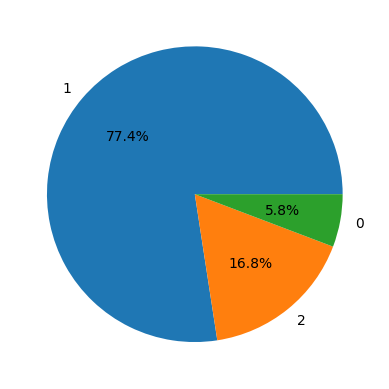

In [46]:
plt.pie(df['class'].value_counts().values, labels=df['class'].value_counts().index, autopct='%1.1f%%')
plt.show()

### Load Cleaned data

In [47]:
df = pd.read_csv('cleaned_data.csv')

In [48]:
# Ensure all entries in the text column are strings
df['tweet'] = df['tweet'].astype(str).fillna('')

### Filter and Encode Labels

In [49]:
df = df[df['class'].isin([0, 1, 2])]
label_mapping = {0: 0, 1: 0, 2: 1}  # Map both offensive and hate speech to the same class (0)
df['label'] = df['class'].map(label_mapping)

### Split Data

In [50]:
X = df['tweet'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

### Tokenize Text and Pad Sequence

In [51]:
# Tokenize Text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)



In [52]:
# Pad Sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

### GloVe Embeddings

In [53]:
def load_glove_embeddings(filepath, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_dim = 100
glove_filepath = 'C:\\group-1-main\\Model-Evaluvation\\DL_Models\\glove.6B.100d.txt'
embedding_matrix = load_glove_embeddings(glove_filepath, tokenizer.word_index, embedding_dim)

print("Shape of training data:", X_train_pad.shape)
print("Shape of test data:", X_test_pad.shape)

Shape of training data: (19826, 100)
Shape of test data: (4957, 100)


### Custom Layer for Mean Reduction

In [54]:
class ReduceMeanLayer(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)

## MODEL

### LSTM Model with Attention

In [55]:
#define model
def create_lstm_attention_model():
    inputs = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False)(inputs)
    lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)
    attention_layer = tf.keras.layers.Attention()([lstm_layer, lstm_layer])
    attention_output = ReduceMeanLayer()(attention_layer)
    dense_layer = Dense(64, activation='relu')(attention_output)
    dropout_layer = Dropout(0.5)(dense_layer)
    outputs = Dense(2, activation='softmax')(dropout_layer)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [56]:
# Create the Model
lstm_attention_model = create_lstm_attention_model()

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Early Stopping and Model Checkpointing

In [57]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0.001, 
                               patience=5, 
                               restore_best_weights=True)
checkpoint_filepath = 'best_lstm_model_checkpoint.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                                   save_best_only=True, 
                                   monitor='val_loss', 
                                   mode='min')

### Model Training

In [58]:
history = lstm_attention_model.fit(X_train_pad,
                                    y_train, 
                                    validation_split=0.2, 
                                    epochs=20, 
                                    batch_size=32, 
                                    callbacks=[early_stopping, model_checkpoint], 
                                    verbose=2)


Epoch 1/20
496/496 - 31s - 62ms/step - accuracy: 0.8858 - loss: 0.2463 - val_accuracy: 0.9198 - val_loss: 0.1584
Epoch 2/20
496/496 - 29s - 59ms/step - accuracy: 0.9177 - loss: 0.1693 - val_accuracy: 0.9241 - val_loss: 0.1485
Epoch 3/20
496/496 - 29s - 58ms/step - accuracy: 0.9228 - loss: 0.1585 - val_accuracy: 0.9349 - val_loss: 0.1451
Epoch 4/20
496/496 - 28s - 57ms/step - accuracy: 0.9296 - loss: 0.1483 - val_accuracy: 0.9380 - val_loss: 0.1388
Epoch 5/20
496/496 - 28s - 57ms/step - accuracy: 0.9342 - loss: 0.1432 - val_accuracy: 0.9387 - val_loss: 0.1424
Epoch 6/20
496/496 - 28s - 57ms/step - accuracy: 0.9403 - loss: 0.1330 - val_accuracy: 0.9400 - val_loss: 0.1391
Epoch 7/20
496/496 - 30s - 60ms/step - accuracy: 0.9446 - loss: 0.1256 - val_accuracy: 0.9402 - val_loss: 0.1415
Epoch 8/20
496/496 - 28s - 57ms/step - accuracy: 0.9500 - loss: 0.1148 - val_accuracy: 0.9395 - val_loss: 0.1517
Epoch 9/20
496/496 - 29s - 59ms/step - accuracy: 0.9549 - loss: 0.1066 - val_accuracy: 0.9402 - 

### Evaluvate the Model

In [59]:
y_pred = np.argmax(lstm_attention_model.predict(X_test_pad), axis=1)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Hate Speech', 'Non-Hate Speech'], digits=4)

155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


In [60]:
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Classification Report:\n{report}")


Accuracy: 0.9301997175711115
F1 Score: 0.9296528526941494
Classification Report:
                 precision    recall  f1-score   support

    Hate Speech     0.9545    0.9619    0.9582      4122
Non-Hate Speech     0.8045    0.7737    0.7888       835

       accuracy                         0.9302      4957
      macro avg     0.8795    0.8678    0.8735      4957
   weighted avg     0.9292    0.9302    0.9297      4957



## Confusion Matrix

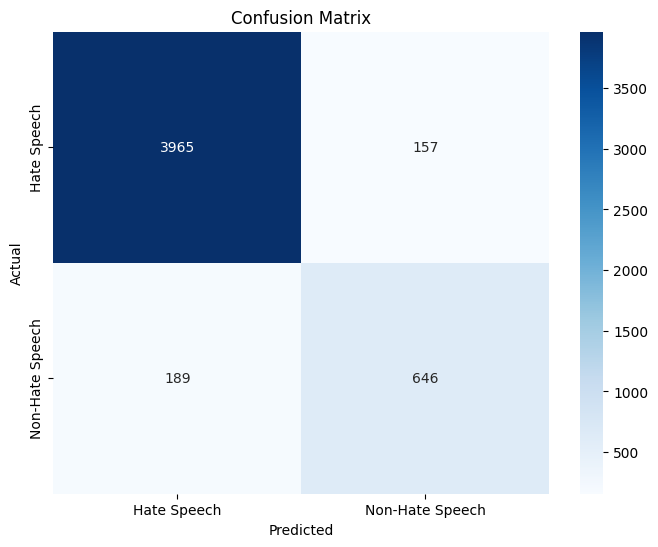

In [61]:

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Non-Hate Speech'], yticklabels=['Hate Speech', 'Non-Hate Speech'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Save the Tokenizer

In [62]:
tokenizer_save_path = 'tokenizer.joblib'
joblib.dump(tokenizer, tokenizer_save_path)
print(f"Tokenizer saved to {tokenizer_save_path}")

Tokenizer saved to tokenizer.joblib


### Save the model

In [63]:
model_save_path = 'best_lstm_model.keras'
lstm_attention_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to best_lstm_model.keras


## PREDICTIONS

### Load the Model

In [64]:
loaded_model = load_model(model_save_path, custom_objects={'ReduceMeanLayer': ReduceMeanLayer})
print("Model loaded from disk.")

Model loaded from disk.


In [66]:
# Load Original Dataset
original_df = pd.read_csv('C:\\group-1-main\\Data-Preprocessing\\labeled_data.csv')

# Ensure all entries in the text column are strings
original_df['tweet'] = original_df['tweet'].astype(str).fillna('')

### Apply the same preprocessing steps

In [67]:

original_df['tweet'] = original_df['tweet'].apply(remove_usernames)
original_df['tweet'] = original_df['tweet'].apply(remove_sequence)
original_df['tweet'] = original_df['tweet'].apply(remove_urls)
original_df['tweet'] = original_df['tweet'].str.lower()
original_df['tweet'] = original_df['tweet'].apply(lambda x: remove_punctuations(x))
original_df['tweet'] = original_df['tweet'].apply(lambda x: replace_words(x.lower(), abbreviations_dict))
original_df['tweet'] = original_df['tweet'].apply(lambda text: remove_stopwords(text))

# Tokenize and Pad the Original Data
original_seq = tokenizer.texts_to_sequences(original_df['tweet'])
original_pad = pad_sequences(original_seq, maxlen=max_length)



### Make Predictions on the Original Dataset

In [68]:

predictions = np.argmax(loaded_model.predict(original_pad), axis=1)


775/775 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step


### Add Predictions to DataFrame

In [69]:

original_df['predictions'] = predictions
print("Predictions added to the original dataset.")
print(original_df.head())

Predictions added to the original dataset.
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  predictions  
0  woman complain cleaning house man always take ...            1  
1              boy coldtyga bad cuffin hoe 1st place            0  
2     friend ever fuck bitch start cry confused shit            0  
3                                   look like tranny            0  
4        shit hear might true might faker bitch told            0  
